In [ ]:
%%capture
# Install 
!pip install git+https://github.com/cschlick/PhenixML.git
# clone for the data files
!git clone https://github.com/cschlick/PhenixML.git 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from phenixml.fragments.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler

from phenixml.visualization.fragment_display import FragmentDisplay
from phenixml.visualization.plotting import plot_geom_eval
from phenixml.utils.torch_utils import to_np
display = FragmentDisplay()

## Process input files
1. Load data
2. Fragment
3. Featurize
4. Label

In [ ]:
# Load molecule containers
containers = MolContainer.from_folder("PhenixML/data/geostd_mol",max_files=500)

100%|██████████| 500/500 [00:00<00:00, 1493.39it/s]


In [ ]:
# Fragment the molecules
fragmenter = AngleFragmenter(exclude_elements=["H"])
fragments = fragmenter(containers)

100%|██████████| 500/500 [00:01<00:00, 352.01it/s]


In [ ]:
# Featurize the fragments
featurizer = MorganFeaturizer()
features = featurizer(fragments,nproc=32)

100%|██████████| 17209/17209 [00:27<00:00, 618.70it/s]


In [ ]:
# label the fragments
labeler = AngleFragmentLabeler()
labels = labeler(fragments)

100%|██████████| 17209/17209 [00:14<00:00, 1157.93it/s]


In [ ]:
# train/test split
from sklearn.model_selection import train_test_split

# Split indices
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)

# select features,labels,fragments
feat_train, feat_test = features[train], features[test]
labels_train, labels_test = labels[train], labels[test]
frags_train = [fragments[i] for i in train]
frags_test = [fragments[i] for i in test]

## Perform kNN analysis

In [ ]:
%%time
from phenixml.models.nn_fragments import FragmentKNN
# Build the pynndescent index
knn = FragmentKNN(frags_train,feat_train,metric="rogerstanimoto")

CPU times: user 1min 7s, sys: 591 ms, total: 1min 8s
Wall time: 58.9 s


In [ ]:
# choose a single query to illustrate kNN search
query_idx = 100
query_frag = frags_test[query_idx]
query_feature = feat_test[query_idx]
query_label = labels_test[query_idx]


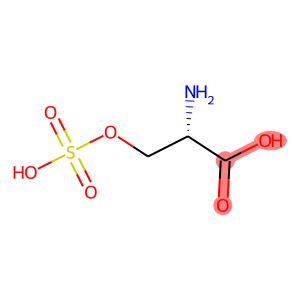

In [ ]:
display(query_frag,hideHs=True,size=(300,300))

In [ ]:
display(query_frag,show3d=True,highlight=False)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# Query the nearest neighbors
nbrs,inds = knn.query(query_feature,k=20, return_ind=True)
nbr_labels = labels_train[inds]

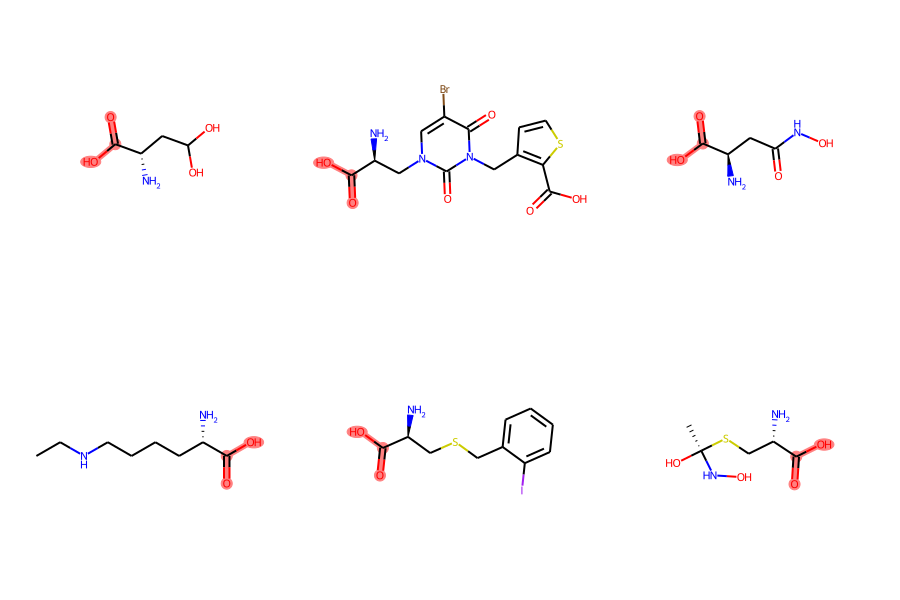

In [ ]:
display(nbrs)

In [ ]:
# Query the knn for the whole test set
nbrs,inds,dists = knn.query(feat_test,k=20, return_ind=True,return_dist=True)
nbr_labels = labels_train[inds]

kNN prediction: 2.115096965516096


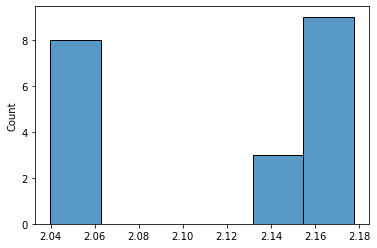

In [ ]:
import seaborn as sns
# plot the kNN labels for the query
sns.histplot(nbr_labels[query_idx])

# take the mean as the predicted value
nbr_mean_label = nbr_labels.mean(axis=1)
print("kNN prediction:",nbr_mean_label[query_idx])

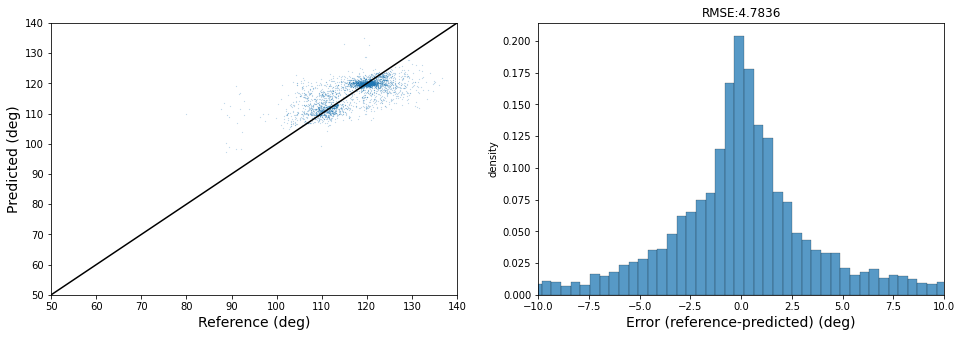

In [ ]:
# plot the results for everything
plot_geom_eval(np.degrees(labels_test),np.degrees(nbr_mean_label),mode="angle")

In [ ]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = np.degrees(labels_test)
labels_test_pred = np.degrees(nbr_mean_label)

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 10
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

Number of mols in test set: 485
Mols better than cutoff: 353
Mols worse than cutoff: 132


## Perform Neural Network Regression

In [ ]:
import torch
from phenixml.models.feature_regression import FeatureModel

In [ ]:
model = FeatureModel(feat_train.shape[1],256,1,n_hid_layers=1)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [ ]:
# set up tensors
feat_train_t = torch.tensor(feat_train,dtype=torch.get_default_dtype())
feat_test_t = torch.tensor(feat_test,dtype=torch.get_default_dtype())
labels_train_t = torch.tensor(labels_train,dtype=torch.get_default_dtype())

In [ ]:
# Split training data into batches

def make_batches(lst, n=50000):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
feature_batches = make_batches(feat_train_t)
label_batches = make_batches(labels_train_t)
batches = list(zip(feature_batches,label_batches))
print("N batches:",len(batches))

N batches: 1


In [ ]:
# train
n_epoch=500
gpuid = None # set to 0,1, etc to specify which gpu (if any)

if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

epoch_losses = []
for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for feat,label in batches:
    if gpuid is not None:
      feat = feat.to("cuda:"+str(gpuid))
      label = label.to("cuda:"+str(gpuid))
    pred = model(feat)[:,0]
    loss = metric(pred,label)
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())
  epoch_losses.append(np.mean(batch_losses))
  
  

100%|██████████| 500/500 [03:22<00:00,  2.47it/s]


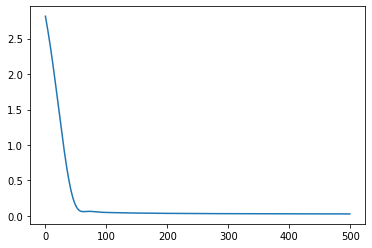

In [ ]:
plt.plot(epoch_losses)

In [ ]:
if gpuid is not None:
  model = model.to("cpu")
pred = model(feat_test_t)

In [ ]:
plot_geom_eval(np.degrees(labels_test),np.degrees(to_np(pred)),mode="angle")

NameError: ignored

In [ ]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = np.degrees(labels_test)
labels_test_pred = np.degrees(nbr_mean_label)

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 10
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)